In [26]:
#import modules
import scipy
import Bio
import math
import matplotlib
from matplotlib import pyplot
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
random_state = numpy.random.RandomState(0)
from pynoci import jadeR
import numpy as np
from numpy import ndarray, float64, matrix, arange
from sklearn.decomposition import FastICA

#import data in tensor form
final_tensor = numpy.load("/Users/polina_turova/Documents/asp/Bigmingham/work folder/numpy arrays/final_tensor_57_samples.npy",allow_pickle=True)
labels = numpy.load("/Users/polina_turova/Documents/asp/Bigmingham/work folder/numpy arrays/labels_57_samples.npy",allow_pickle=True)
al_time = numpy.arange(3.02,22.0,0.05)

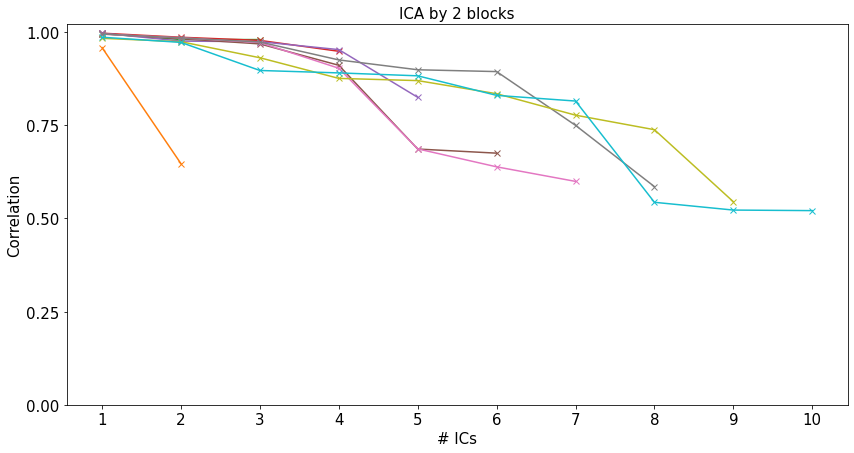

In [8]:
#unfold data tensor
final_tensor_unfolded =[]
for i in range (len(final_tensor)):
    final_tensor_unfolded.append(final_tensor[i].flatten())
final_tensor_unfolded = numpy.array(final_tensor_unfolded)

#define number of components with ICA-by-blocks approach
def ICA_by_two_blocks(X,maxICs=None,verbose=1):
    """
    ICA_by_two_blocks Optimal Number of Independant Components determination with ICA by blocks method

    Input parameters:
        X: MxN matrix. N samples of M sensors.
        maxICs: maximun ICs for calculations
    verbose: 0 no verbose, 1 plot correlation_data

    Output parameters:
        correlation_data: Cell Array with correlation data

    Author: Daniel Mercader (mercaderd@yahoo.es)
    Universidad Nacional de Educación a Distancia

    :param X: MxN matrix. N samples of M sensors.
    :param maxICs: maximun ICs for calculations
    :param verbose: 0 no verbose, 1 plot correlation_data
    :return: list with correlation data matrices
    """
    assert isinstance(X, ndarray), \
        "X (input data matrix) is of the wrong type (%s)" % type(X)
    X = matrix(X.astype(float64))
    assert X.ndim == 2, "X has %d dimensions, should be 2" % X.ndim
    assert (verbose == 0) or (verbose == 1) or (verbose == 2), \
        "verbose parameter should be either 0 or 1 or 2"
    [n, T] = X.shape
    assert n < T, "number of sensors must be smaller than number of samples"
    nblocks = 2
    block_length = np.floor_divide(n, nblocks)
    if maxICs == None:
        maxICs = block_length
    assert maxICs <= block_length, \
        "number of sources (%d) is larger than number of sensors (%d )" % (maxICs, n)
    nblocks = 2
    blocks = np.empty([block_length, T, nblocks])
    #choose equivalent blocks by any other method 
    ind_1 = ([0,1,3,6,7, 9, 12,13,15,18,19,21,24,25,27,30,31,33,36,37,39,42,43,45,48,49,51,54])
    ind_2 = ([2,4,5,8,10,11,14,16,17,20,22,23,26,28,29,32,34,35,38,40,41,44,46,47,50,52,53,56])
    blocks[:,:, 0] = X[ind_1]    
    blocks[:,:, 1] = X[ind_2]  
    correlation_data = []
    for i in arange(maxICs):
        B1 = jadeR.jadeR(blocks[:, :, 0], m=i + 1)
        B2 = jadeR.jadeR(blocks[:, :, 1], m=i + 1)
        Y1 = B1 * matrix(blocks[:, :, 0])
        Y2 = B2 * matrix(blocks[:, :, 1])
        CMat = np.sort(np.nanmax(np.abs(np.corrcoef(Y1, Y2)[:i + 1, i + 1:]), axis=1))
        #print(np.corrcoef(Y1, Y2)[:i + 1, i + 1:])
        #print(CMat)
        correlation_data.append(CMat[::-1]) #Append correlations in descent order
    fig, ax = pyplot.subplots(figsize=(14,7))
    if verbose  > 0:
        for correlation in correlation_data:
            plt.plot(correlation,marker='x')
        if maxICs>10:
            xRange = np.arange(0,maxICs,np.floor_divide(maxICs,10))
        else:
            xRange = np.arange(0,maxICs,1)
        ax.tick_params(color="black",labelsize=15,colors="black",grid_color="black")
        plt.xticks(xRange, xRange + 1)
        plt.yticks([0,0.25,0.5,0.75,1])
        plt.title('ICA by 2 blocks', size=15)
        plt.xlabel("# ICs",size=15)
        plt.ylabel("Correlation",size=15)
        plt.show()
    return correlation_data
blocks = ICA_by_two_blocks(final_tensor_unfolded,maxICs=10)

In [21]:
ICA = FastICA(n_components = 4,max_iter = 10000,tol = 0.05)
basis=ICA.fit_transform(final_tensor_unfolded)
components = ICA.components_

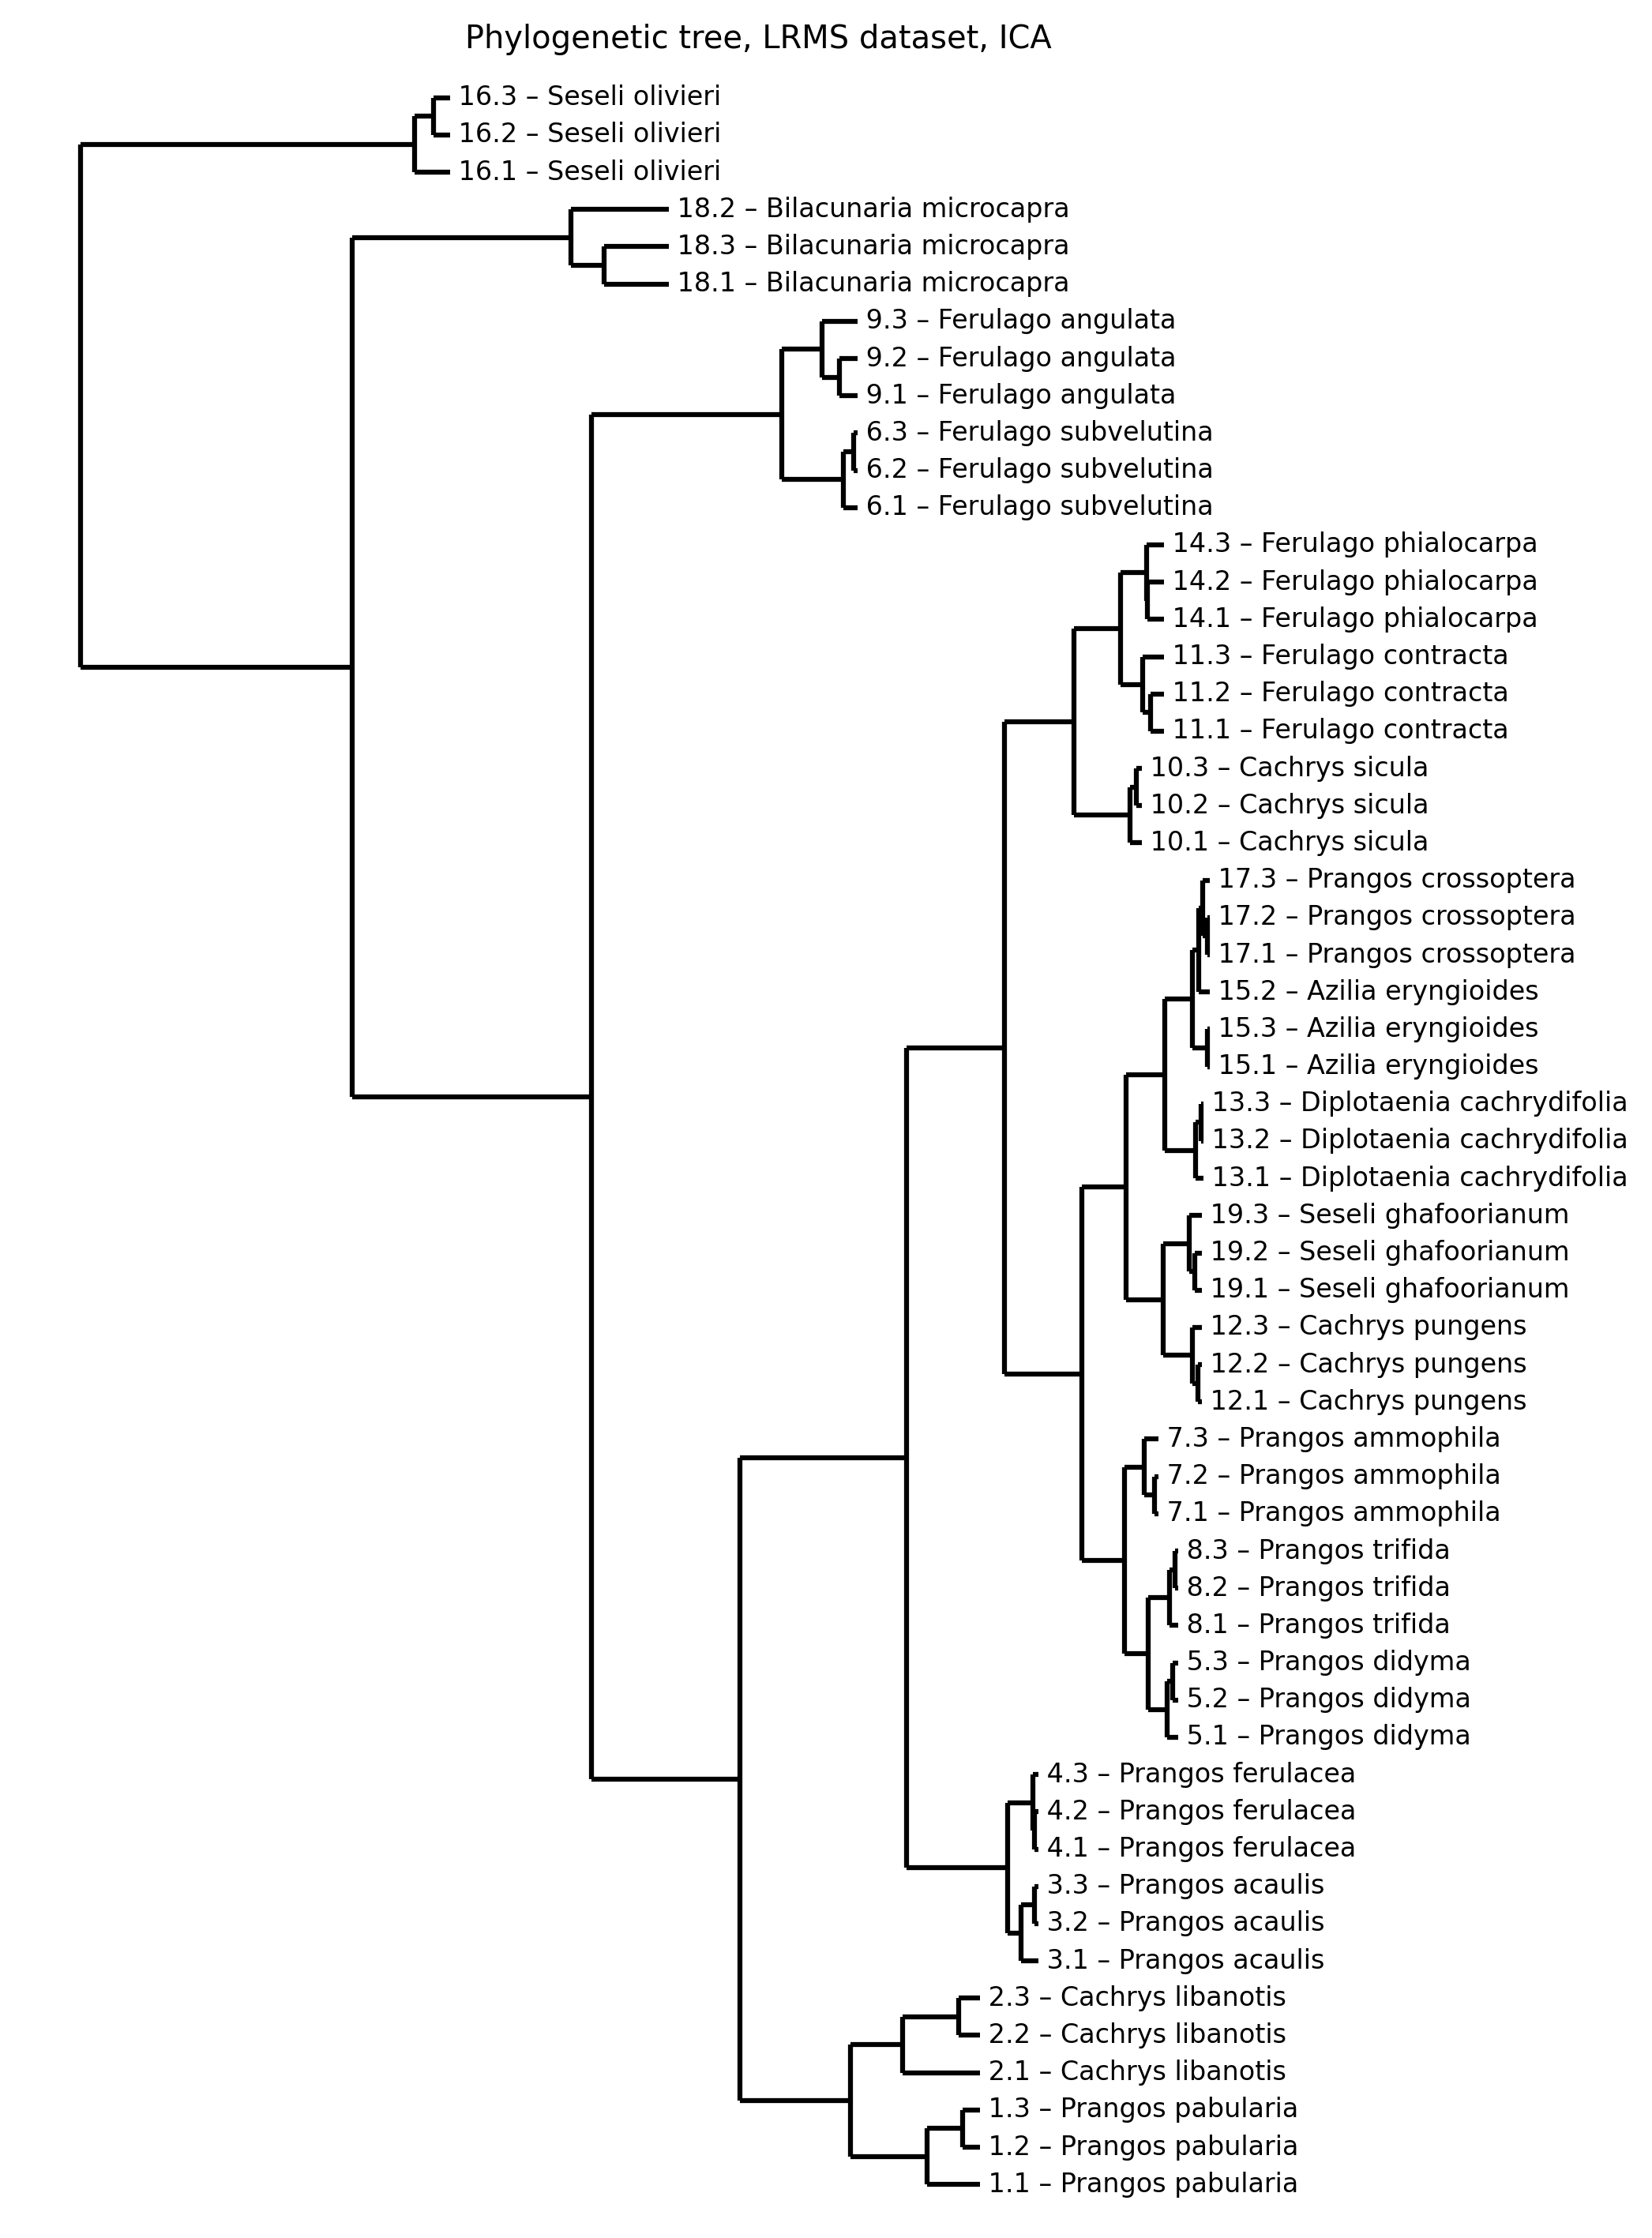

In [22]:
#Visualize phylogenetic tree for ICA decomposition
labels_list = ['1.1 – Prangos pabularia','1.2 – Prangos pabularia','1.3 – Prangos pabularia',
        '2.1 – Cachrys libanotis','2.2 – Cachrys libanotis',
        '2.3 – Cachrys libanotis',
        '3.1 – Prangos acaulis','3.2 – Prangos acaulis','3.3 – Prangos acaulis',
        '4.1 – Prangos ferulacea','4.2 – Prangos ferulacea','4.3 – Prangos ferulacea',
        '5.1 – Prangos didyma','5.2 – Prangos didyma','5.3 – Prangos didyma',
        '6.1 – Ferulago subvelutina',
        '6.2 – Ferulago subvelutina','6.3 – Ferulago subvelutina ',
        '7.1 – Prangos ammophila','7.2 – Prangos ammophila','7.3 – Prangos ammophila',
        '8.1 – Prangos trifida','8.2 – Prangos trifida','8.3 – Prangos trifida',
        '9.1 – Ferulago angulata','9.2 – Ferulago angulata',
        '9.3 – Ferulago angulata',
        '10.1 – Cachrys sicula','10.2 – Cachrys sicula', '10.3 – Cachrys sicula',
        '11.1 – Ferulago contracta','11.2 – Ferulago contracta','11.3 – Ferulago contracta',
        '12.1 – Cachrys pungens',
        '12.2 – Cachrys pungens', '12.3 – Cachrys pungens',
        '13.1 – Diplotaenia cachrydifolia','13.2 – Diplotaenia cachrydifolia','13.3 – Diplotaenia cachrydifolia',
        '14.1 – Ferulago phialocarpa','14.2 – Ferulago phialocarpa','14.3 – Ferulago phialocarpa',
        '15.1 – Azilia eryngioides','15.2 – Azilia eryngioides','15.3 – Azilia eryngioides',
        '16.1 – Seseli olivieri', '16.2 – Seseli olivieri', '16.3 – Seseli olivieri',
        '17.1 – Prangos crossoptera', '17.2 – Prangos crossoptera',
        '17.3 – Prangos crossoptera',
        '18.1 – Bilacunaria microcapra',
        '18.2 – Bilacunaria microcapra','18.3 – Bilacunaria microcapra',
        '19.1 – Seseli ghafoorianum','19.2 – Seseli ghafoorianum','19.3 – Seseli ghafoorianum']

column_list = numpy.arange(1,len(components)+1)

from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import AlignIO

import pandas as pd
my_dataframe = pd.DataFrame(data=basis,index=labels_list,columns=column_list)

from scipy.spatial import distance_matrix
dist = distance_matrix(my_dataframe.values, my_dataframe.values)
dist_list = dist.tolist()

for i in range (len(dist_list)-1):
    del dist_list[i][i+1:len(labels)]
    
dist_bio = Bio.Phylo.TreeConstruction.DistanceMatrix(labels_list, matrix=dist_list)

constructor = DistanceTreeConstructor(method = 'upgma')
tree = constructor.upgma(dist_bio)

for i in range (1,len(labels_list)):
    name_clade = 'Inner' + str(i)
    tree.common_ancestor({"name": name_clade}).name=''
    
from matplotlib import pyplot as plt
matplotlib.rc('font', size=8)
fig = plt.figure(figsize=(8, 12), dpi=300)
axes = fig.add_subplot(1, 1, 1)
plt.title("Phylogenetic tree, LRMS dataset, ICA")
plt.box(on=None)
plt.axis('off')
Phylo.draw(tree, axes=axes)

In [24]:
#create list of signals with highest weights responsible for 50 compounds
features_list = []
features = []
features_ratio = []
for k in range (len(components)):
    features.append(numpy.argsort(abs(components[k])))
    features_ratio.append(numpy.sort(abs(components[k])))
z = 1
i = 1
mass = []
time = []
mass.append(features[0][-1]%1200+100)
time.append(round(al_time[features[0][-1]//1200],2))
features_list.append(features[0][-1])
features[0] = numpy.delete(features[0], -1)
while z < 50:
    for k in range (len(components)):
        if z == 50:
            break
        control = 0
        while control == 0:
            mass.append(features[k][-1]%1200+100)
            time.append(round(al_time[features[k][-1]//1200],2))
            j = 1
            features_list.append(features[k][-1])
            features[k] = numpy.delete(features[k], -1)
            res_m = math.isclose(mass[-1],mass[-j-1],abs_tol=2)
            res_t = math.isclose(time[-1],mass[-j-1],abs_tol=0.4)

            while (j != len(mass)):
                res_m = math.isclose(mass[-1],mass[-j-1],abs_tol=2)
                res_t = math.isclose(time[-1],time[-j-1],abs_tol=0.4)
                j = j + 1
                if (res_m == True) and (res_t == True):
                    break
            else:
                control = 1
                z = z+1
features_list = numpy.array(features_list)
numpy.save("/Users/polina_turova/Documents/asp/Bigmingham/work folder/numpy arrays/features_ica.npy",features_list)

In [28]:
#labels for 19 classes
cluster_labels = []
for i in range (len(labels)):
    cluster_labels.append(int(int(labels[i])//100))  

# Binarize the output
y_bin = label_binarize(cluster_labels, classes=[1,3,4,5,6,7,8,9,10,11,13,14,16,18,19,20,21,22,23])
n_classes = y_bin.shape[1]
X_train, X_test, y_train, y_test = train_test_split(basis, y_bin, test_size=.5,stratify=y_bin,random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = numpy.unique(numpy.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = numpy.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += numpy.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print (roc_auc["macro"])

0.9073377889167362
